In [56]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

nltk.download('punkt', download_dir='/usr/share/nltk_data', force=True)
nltk.download('wordnet', download_dir='/usr/share/nltk_data', force=True)
nltk.download('omw-1.4', download_dir='/usr/share/nltk_data', force=True)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [57]:
# Read a Parquet file
df_train = pd.read_parquet('train.parquet')
df_val = pd.read_parquet('validation.parquet')
df_test = pd.read_parquet('test.parquet')


 # Part 1: Data Preprocessing and Baseline Modeling


## Data cleaning and preprocessing

In [58]:
tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)


In [59]:
df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_val['cleaned_text'] = df_val['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)
df_train[['text', 'cleaned_text', 'label']].head()

,text,cleaned_text,label
0,"""QT @user In the original draft of the 7th boo...",qt in the original draft of the th book remus ...,2
1,"""Ben Smith / Smith (concussion) remains out of...",ben smith smith concussion remains out of the ...,1
2,Sorry bout the stream last night I crashed out...,sorry bout the stream last night i crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,chase headleys rbi double in the th inning off...,1
4,@user Alciato: Bee will invest 150 million in ...,alciato bee will invest million in january ano...,2


## exploratory data analysis (EDA)

In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45615 entries, 0 to 45614
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          45615 non-null  object
 1   label         45615 non-null  int64 
 2   cleaned_text  45615 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [61]:
# for index,text in enumerate(df['cleaned_text'][35:40]):
#   print('Review %d:\n'%(index+1),text)

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from nltk.corpus import stopwords

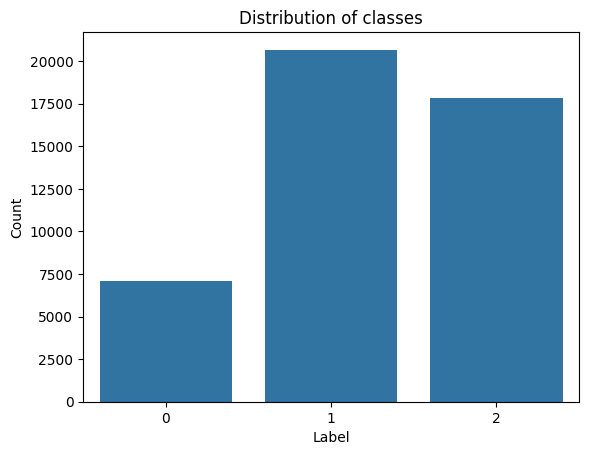

In [63]:
x_axis = df_train['label'].value_counts()
sns.barplot(x=x_axis.index, y=x_axis.values)
plt.title('Distribution of classes')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [64]:
####### problem: stop words should've been dropped?
word_count = defaultdict(Counter)
for _, row in df_train.iterrows():
    label = row['label']
    text = row['cleaned_text']
    words = text.split()
    word_count[label].update(words)

for label,counter in word_count.items():
  print(f"Label: {label}")
  for word, count in counter.most_common(3):
    print(f"{word}: {count}")
  print(f"\n")

Label: 2
the: 14316
to: 8464
a: 5932


Label: 1
the: 17825
to: 9197
in: 6557


Label: 0
the: 5789
to: 3243
a: 2780




In [65]:
df_train['word_count'] = df_train['cleaned_text'].apply(lambda x: len(str(x).split()))
print(f"Avg number of words in label 0:\n {df_train[df_train['label']==0]['word_count'].mean()}")
print(f"Avg number of words in label 1:\n {df_train[df_train['label']==1]['word_count'].mean()}")
print(f"Avg number of words in label 2:\n {df_train[df_train['label']==2]['word_count'].mean()}")


Avg number of words in label 0:
 19.324686310446918
Avg number of words in label 1:
 17.81671745755333
Avg number of words in label 2:
 18.04325172278559


Text(0.5, 1.0, 'Class 2')

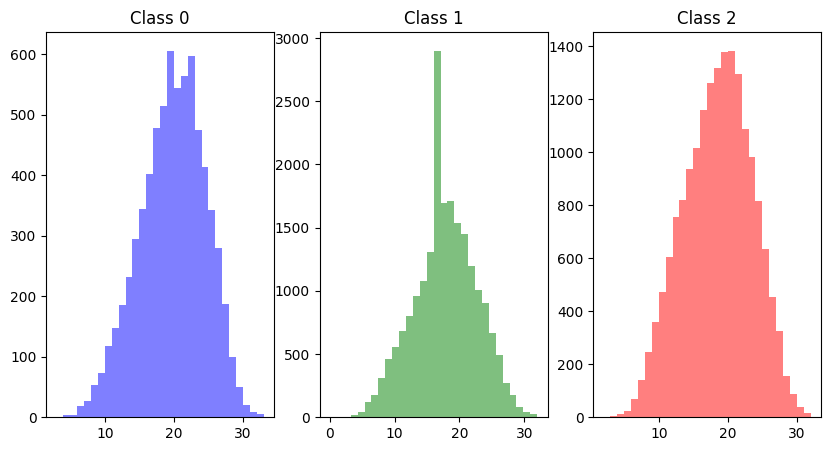

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
train_words = df_train[df_train['label']==0]['word_count']
ax1.hist(train_words, bins=30, alpha=0.5, color='blue', label='Label 0')
ax1.set_title('Class 0')
train_words = df_train[df_train['label']==1]['word_count']
ax2.hist(train_words, bins=30, alpha=0.5, color='green', label='Label 1')
ax2.set_title('Class 1')
train_words = df_train[df_train['label']==2]['word_count']
ax3.hist(train_words, bins=30, alpha=0.5, color='red', label='Label 2')
ax3.set_title('Class 2')

## Models + Respective Trials:

## Feedforward-based model

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from collections import Counter

In [68]:
tokenized_train = [tweet.split() for tweet in df_train['cleaned_text']]
tokenized_val = [tweet.split() for tweet in df_val['cleaned_text']]
tokenized_test = [tweet.split() for tweet in df_test['cleaned_text']]

In [69]:
word_counts = Counter(token for tweet in tokenized_train for token in tweet)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

In [70]:
def encode_and_pad(tokenized_tweets, vocab, max_len=50):
    encoded = []
    for tweet in tokenized_tweets:
        ids = [vocab.get(token, vocab["<UNK>"]) for token in tweet]
        if len(ids) < max_len:
            ids += [vocab["<PAD>"]] * (max_len - len(ids))
        else:
            ids = ids[:max_len]
        encoded.append(ids)
    return torch.tensor(encoded)

In [71]:
X_train = encode_and_pad(tokenized_train, vocab)
X_val = encode_and_pad(tokenized_val, vocab)
X_test = encode_and_pad(tokenized_test, vocab)

In [72]:
y_train = torch.tensor(df_train['label'].values)
y_val = torch.tensor(df_val['label'].values)
y_test = torch.tensor(df_test['label'].values)

In [73]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [75]:
MAX_LEN = 50
class FeedforwardNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super(FeedforwardNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.fc1 = nn.Linear(embed_dim * MAX_LEN, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3  # positive, negative, neutral
PAD_IDX = vocab["<PAD>"]

model = FeedforwardNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Lists to save history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

EPOCHS = 10
best_val_loss = float('inf')
patience = 2
counter = 0

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    # Save history
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    print(f'Epoch [{epoch+1}/{EPOCHS}] '
          f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} || '
          f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}')
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break




Epoch [1/10] Train Loss: 0.9923 | Train Acc: 0.4934 || Val Loss: 0.9539 | Val Acc: 0.5240
Epoch [2/10] Train Loss: 0.8691 | Train Acc: 0.5886 || Val Loss: 0.9059 | Val Acc: 0.5640
Epoch [3/10] Train Loss: 0.7411 | Train Acc: 0.6665 || Val Loss: 0.9018 | Val Acc: 0.5710
Epoch [4/10] Train Loss: 0.6211 | Train Acc: 0.7298 || Val Loss: 0.9232 | Val Acc: 0.5815
Epoch [5/10] Train Loss: 0.5144 | Train Acc: 0.7854 || Val Loss: 0.9639 | Val Acc: 0.6060
Early stopping triggered!


In [76]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

FeedforwardNN(
  (embedding): Embedding(40136, 100, padding_idx=0)
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [77]:
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f'Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}')


Test Loss: 0.9950 | Test Acc: 0.5254


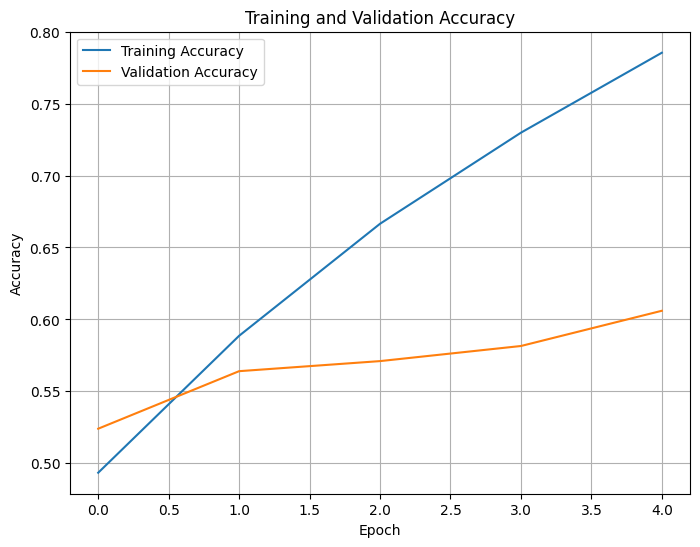

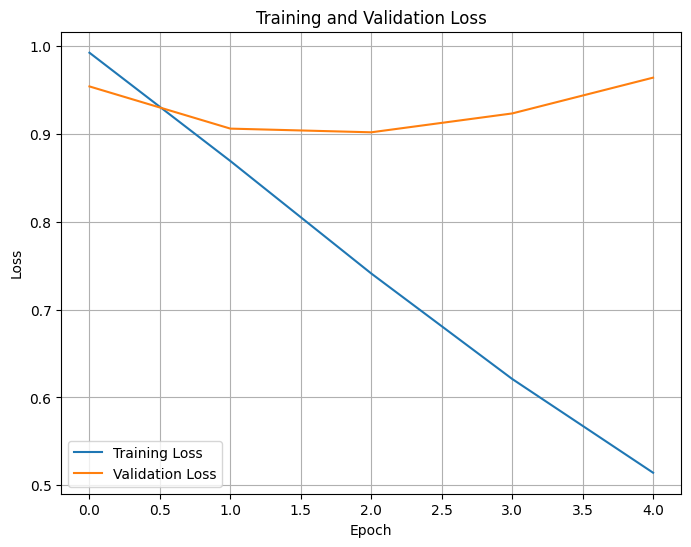

In [78]:
import matplotlib.pyplot as plt

# Accuracy curves
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Loss curves
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


The training and validation accuracy curves show that the model is able to learn from the training data, as indicated by the rising training accuracy. However, the validation accuracy plateaus early, suggesting that the model begins to overfit after the second epoch. This implies limited generalization capability, likely due to insufficient data, limited regularization, or overly complex model parameters.

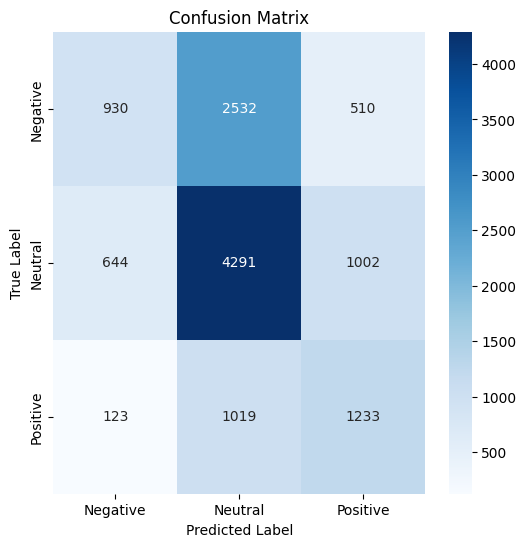

              precision    recall  f1-score   support

    Negative       0.55      0.23      0.33      3972
     Neutral       0.55      0.72      0.62      5937
    Positive       0.45      0.52      0.48      2375

    accuracy                           0.53     12284
   macro avg       0.51      0.49      0.48     12284
weighted avg       0.53      0.53      0.50     12284



In [79]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))


The confusion matrix analysis reveals that the current feedforward neural network (FFNN) model demonstrates a bias toward predicting the Neutral class, often at the expense of correctly identifying Negative and Positive sentiments. While the model performs relatively well on Neutral inputs (with 4326 correctly classified out of 5937), it misclassifies a significant number of Negative and Positive samples as Neutral.

##Trial1

In [80]:
df_train1 = pd.read_parquet('train.parquet')
df_val1 = pd.read_parquet('validation.parquet')
df_test1 = pd.read_parquet('test.parquet')

In [82]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text2(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    # remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
df_train1['cleaned_text'] = df_train['text'].apply(clean_text2)
df_val1['cleaned_text'] = df_val['text'].apply(clean_text2)
df_test1['cleaned_text'] = df_test['text'].apply(clean_text2)
df_train1[['text', 'cleaned_text', 'label']].head()

,text,cleaned_text,label
0,"""QT @user In the original draft of the 7th boo...",qt original draft th book remus lupin survived...,2
1,"""Ben Smith / Smith (concussion) remains out of...",ben smith smith concussion remains lineup thur...,1
2,Sorry bout the stream last night I crashed out...,sorry bout stream last night crashed tonight s...,1
3,Chase Headley's RBI double in the 8th inning o...,chase headleys rbi double th inning david pric...,1
4,@user Alciato: Bee will invest 150 million in ...,alciato bee invest million january another sum...,2


In [84]:
tokenized_train1 = [tweet.split() for tweet in df_train1['cleaned_text']]
tokenized_val1 = [tweet.split() for tweet in df_val1['cleaned_text']]
tokenized_test1 = [tweet.split() for tweet in df_test1['cleaned_text']]

In [85]:
word_counts = Counter(token for tweet in tokenized_train1 for token in tweet)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

In [86]:
X_train1 = encode_and_pad(tokenized_train1, vocab)
X_val1 = encode_and_pad(tokenized_val1, vocab)
X_test1 = encode_and_pad(tokenized_test1, vocab)

In [87]:
y_train1 = torch.tensor(df_train1['label'].values)
y_val1 = torch.tensor(df_val1['label'].values)
y_test1 = torch.tensor(df_test1['label'].values)

In [88]:
train_dataset1 = torch.utils.data.TensorDataset(X_train1, y_train1)
val_dataset1 = torch.utils.data.TensorDataset(X_val1, y_val1)
test_dataset1 = torch.utils.data.TensorDataset(X_test1, y_test1)

train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=32, shuffle=True)
val_loader1 = torch.utils.data.DataLoader(val_dataset1, batch_size=32)
test_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=32)

In [89]:

MAX_LEN = 50
class FeedforwardNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super(FeedforwardNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.fc1 = nn.Linear(embed_dim * MAX_LEN, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = 3  # positive, negative, neutral
PAD_IDX = vocab["<PAD>"]

model = FeedforwardNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)


criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Lists to save history
train_losses1 = []
train_accuracies1 = []
val_losses1 = []
val_accuracies1 = []

EPOCHS = 10
best_val_loss = float('inf')
patience = 2  # number of epochs to wait before stopping
counter = 0

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader1:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader1)

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader1:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader1)

    train_losses1.append(avg_train_loss)
    train_accuracies1.append(train_acc)
    val_losses1.append(avg_val_loss)
    val_accuracies1.append(val_acc)


    print(f'Epoch [{epoch+1}/{EPOCHS}] '
          f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} || '
          f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}')
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break




Epoch [1/10] Train Loss: 0.9860 | Train Acc: 0.5058 || Val Loss: 0.9532 | Val Acc: 0.5245
Epoch [2/10] Train Loss: 0.8710 | Train Acc: 0.5915 || Val Loss: 0.8965 | Val Acc: 0.5685
Epoch [3/10] Train Loss: 0.7727 | Train Acc: 0.6509 || Val Loss: 0.8764 | Val Acc: 0.5895
Epoch [4/10] Train Loss: 0.6894 | Train Acc: 0.6969 || Val Loss: 0.8762 | Val Acc: 0.6035
Epoch [5/10] Train Loss: 0.6117 | Train Acc: 0.7374 || Val Loss: 0.9032 | Val Acc: 0.6165
Epoch [6/10] Train Loss: 0.5466 | Train Acc: 0.7699 || Val Loss: 0.9287 | Val Acc: 0.6320
Early stopping triggered!


In [90]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

FeedforwardNN(
  (embedding): Embedding(40029, 100, padding_idx=0)
  (fc1): Linear(in_features=5000, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [91]:
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader1:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
avg_test_loss = test_loss / len(test_loader1)

print(f'Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.9878 | Test Acc: 0.5395


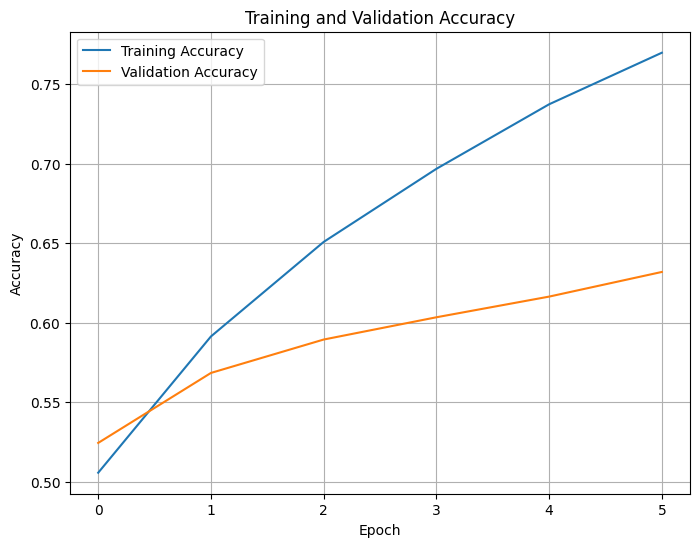

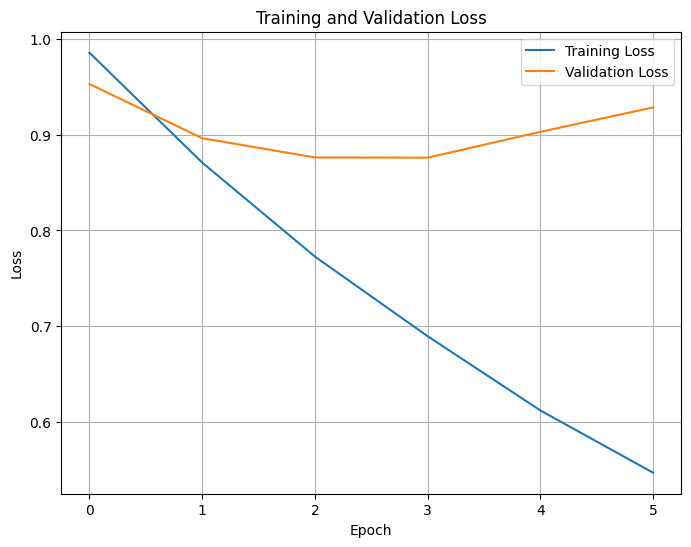

In [92]:
import matplotlib.pyplot as plt

# Accuracy curves
plt.figure(figsize=(8,6))
plt.plot(train_accuracies1, label='Training Accuracy')
plt.plot(val_accuracies1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Loss curves
plt.figure(figsize=(8,6))
plt.plot(train_losses1, label='Training Loss')
plt.plot(val_losses1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

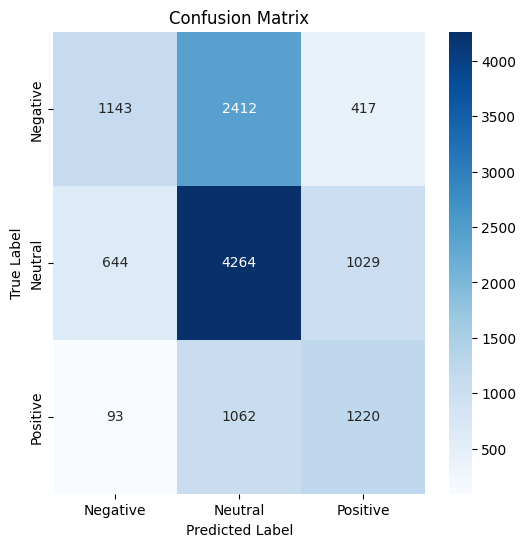

              precision    recall  f1-score   support

    Negative       0.61      0.29      0.39      3972
     Neutral       0.55      0.72      0.62      5937
    Positive       0.46      0.51      0.48      2375

    accuracy                           0.54     12284
   macro avg       0.54      0.51      0.50     12284
weighted avg       0.55      0.54      0.52     12284



In [93]:
# Predict on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader1:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

In Trial 1, I removed English stopwords during preprocessing to eliminate non-sentiment-bearing words like "the", "to", and "a".
This led to a slight improvement in overall accuracy (from 52% to 53.95%) and macro F1-score (from 0.53 to 0.54).
This suggests that reducing noise helped the model focus on more meaningful words that express sentiment.

## Trial 2 — Using Pre-trained GloVe Embeddings


In [94]:
df_train2 = pd.read_parquet('train.parquet')
df_val2 = pd.read_parquet('validation.parquet')
df_test2 = pd.read_parquet('test.parquet')

In [95]:
df_train2['cleaned_text'] = df_train2['text'].apply(clean_text2)
df_val2['cleaned_text'] = df_val2['text'].apply(clean_text2)
df_test2['cleaned_text'] = df_test2['text'].apply(clean_text2)
df_train2[['text', 'cleaned_text', 'label']].head()

,text,cleaned_text,label
0,"""QT @user In the original draft of the 7th boo...",qt original draft th book remus lupin survived...,2
1,"""Ben Smith / Smith (concussion) remains out of...",ben smith smith concussion remains lineup thur...,1
2,Sorry bout the stream last night I crashed out...,sorry bout stream last night crashed tonight s...,1
3,Chase Headley's RBI double in the 8th inning o...,chase headleys rbi double th inning david pric...,1
4,@user Alciato: Bee will invest 150 million in ...,alciato bee invest million january another sum...,2


In [96]:
tokenized_train2 = [tweet.split() for tweet in df_train2['cleaned_text']]
tokenized_val2 = [tweet.split() for tweet in df_val2['cleaned_text']]
tokenized_test2 = [tweet.split() for tweet in df_test2['cleaned_text']]

In [97]:
word_counts = Counter(token for tweet in tokenized_train2 for token in tweet)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

In [98]:
X_train2 = encode_and_pad(tokenized_train2, vocab)
X_val2 = encode_and_pad(tokenized_val2, vocab)
X_test2 = encode_and_pad(tokenized_test2, vocab)

In [99]:
y_train2 = torch.tensor(df_train2['label'].values)
y_val2 = torch.tensor(df_val2['label'].values)
y_test2 = torch.tensor(df_test2['label'].values)

In [100]:
train_dataset2 = torch.utils.data.TensorDataset(X_train2, y_train2)
val_dataset2 = torch.utils.data.TensorDataset(X_val2, y_val2)
test_dataset2 = torch.utils.data.TensorDataset(X_test2, y_test2)

train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=32, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(val_dataset2, batch_size=32)
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=32)

In [101]:
# Load GloVe embeddings
glove_path = "glove.6B.100d.txt"
embedding_dim = 100

glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = torch.tensor(list(map(float, parts[1:])))
        glove_embeddings[word] = vector


In [102]:
embedding_matrix = torch.zeros(len(vocab), embedding_dim)
for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim) * 0.6


In [103]:
MAX_LEN = 50
class GloveFeedforwardNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, pad_idx):
        super(GloveFeedforwardNN, self).__init__()
        num_embeddings, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=pad_idx)
        self.fc1 = nn.Linear(embed_dim * MAX_LEN, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3  # positive, negative, neutral
PAD_IDX = vocab["<PAD>"]

model_glove = GloveFeedforwardNN(embedding_matrix, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model_glove.parameters(), lr=0.0005, weight_decay=1e-5)

# Lists to save history
train_losses2 = []
train_accuracies2 = []
val_losses2 = []
val_accuracies2 = []

EPOCHS = 10
best_val_loss = float('inf')
patience = 2
counter = 0

for epoch in range(EPOCHS):
    # --- Training ---
    model_glove.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader2:
        optimizer.zero_grad()
        outputs = model_glove(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader2)

    # --- Validation ---
    model_glove.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader2:
            outputs = model_glove(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader2)

    train_losses2.append(avg_train_loss)
    train_accuracies2.append(train_acc)
    val_losses2.append(avg_val_loss)
    val_accuracies2.append(val_acc)


    print(f'Epoch [{epoch+1}/{EPOCHS}] '
          f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} || '
          f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}')
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model_glove.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break


Epoch [1/10] Train Loss: 0.9748 | Train Acc: 0.4860 || Val Loss: 0.8851 | Val Acc: 0.5845
Epoch [2/10] Train Loss: 0.8381 | Train Acc: 0.5947 || Val Loss: 0.7860 | Val Acc: 0.6480
Epoch [3/10] Train Loss: 0.7328 | Train Acc: 0.6672 || Val Loss: 0.7640 | Val Acc: 0.6585
Epoch [4/10] Train Loss: 0.6394 | Train Acc: 0.7216 || Val Loss: 0.7727 | Val Acc: 0.6640
Epoch [5/10] Train Loss: 0.5396 | Train Acc: 0.7753 || Val Loss: 0.8172 | Val Acc: 0.6605
Early stopping triggered!


In [104]:
model_glove.load_state_dict(torch.load('best_model.pt'))
model_glove.eval()

GloveFeedforwardNN(
  (embedding): Embedding(40029, 100, padding_idx=0)
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [105]:
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader2:
        outputs = model_glove(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
avg_test_loss = test_loss / len(test_loader2)

print(f'Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.8627 | Test Acc: 0.6095


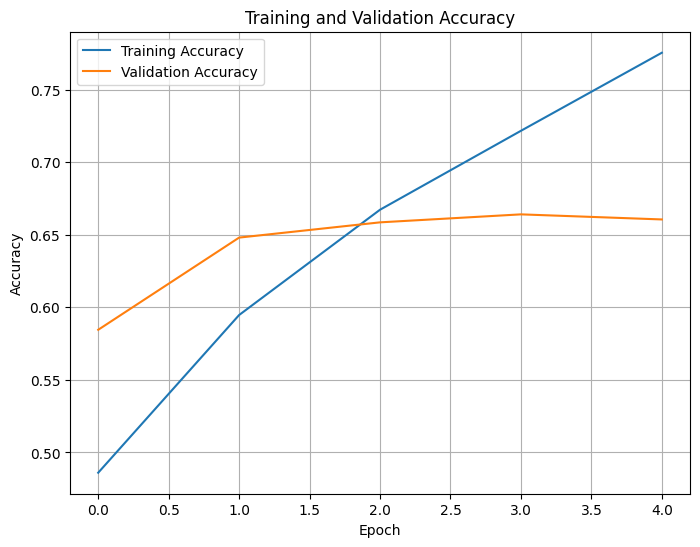

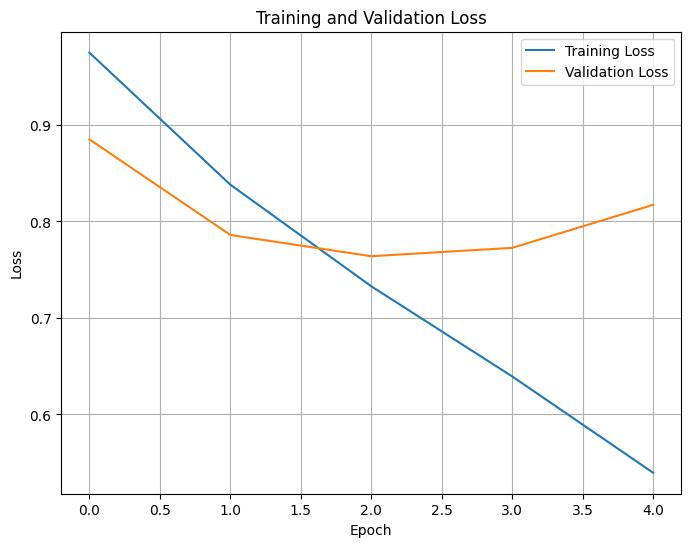

In [106]:
import matplotlib.pyplot as plt

# Accuracy curves
plt.figure(figsize=(8,6))
plt.plot(train_accuracies2, label='Training Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Loss curves
plt.figure(figsize=(8,6))
plt.plot(train_losses2, label='Training Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

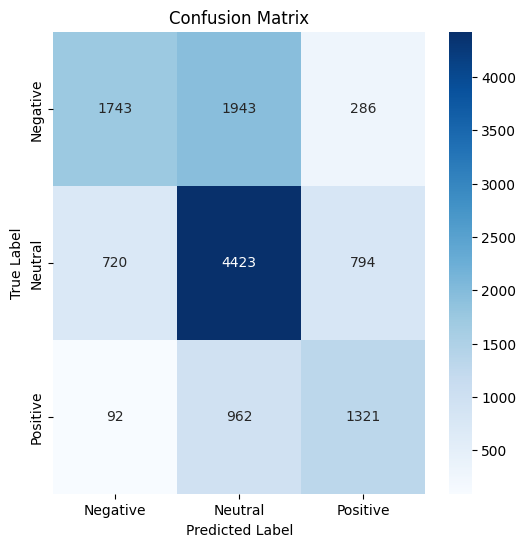

              precision    recall  f1-score   support

    Negative       0.68      0.44      0.53      3972
     Neutral       0.60      0.74      0.67      5937
    Positive       0.55      0.56      0.55      2375

    accuracy                           0.61     12284
   macro avg       0.61      0.58      0.58     12284
weighted avg       0.62      0.61      0.60     12284



In [107]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Predict on test set
model_glove.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader2:
        outputs = model_glove(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

In Trial 2, I used pretraind embedding glove.
This led to an improvement in overall accuracy (from 53.95% to 60%) .
Using GloVe embeddings improved the model’s accuracy because these pretrained word vectors capture rich semantic relationships between words, learned from large text corpora. Unlike randomly initialized embeddings, GloVe provides the model with meaningful representations from the start, allowing it to better understand context and word similarity. This leads to faster learning, more accurate feature extraction, and improved generalization to unseen data, ultimately boosting performance.

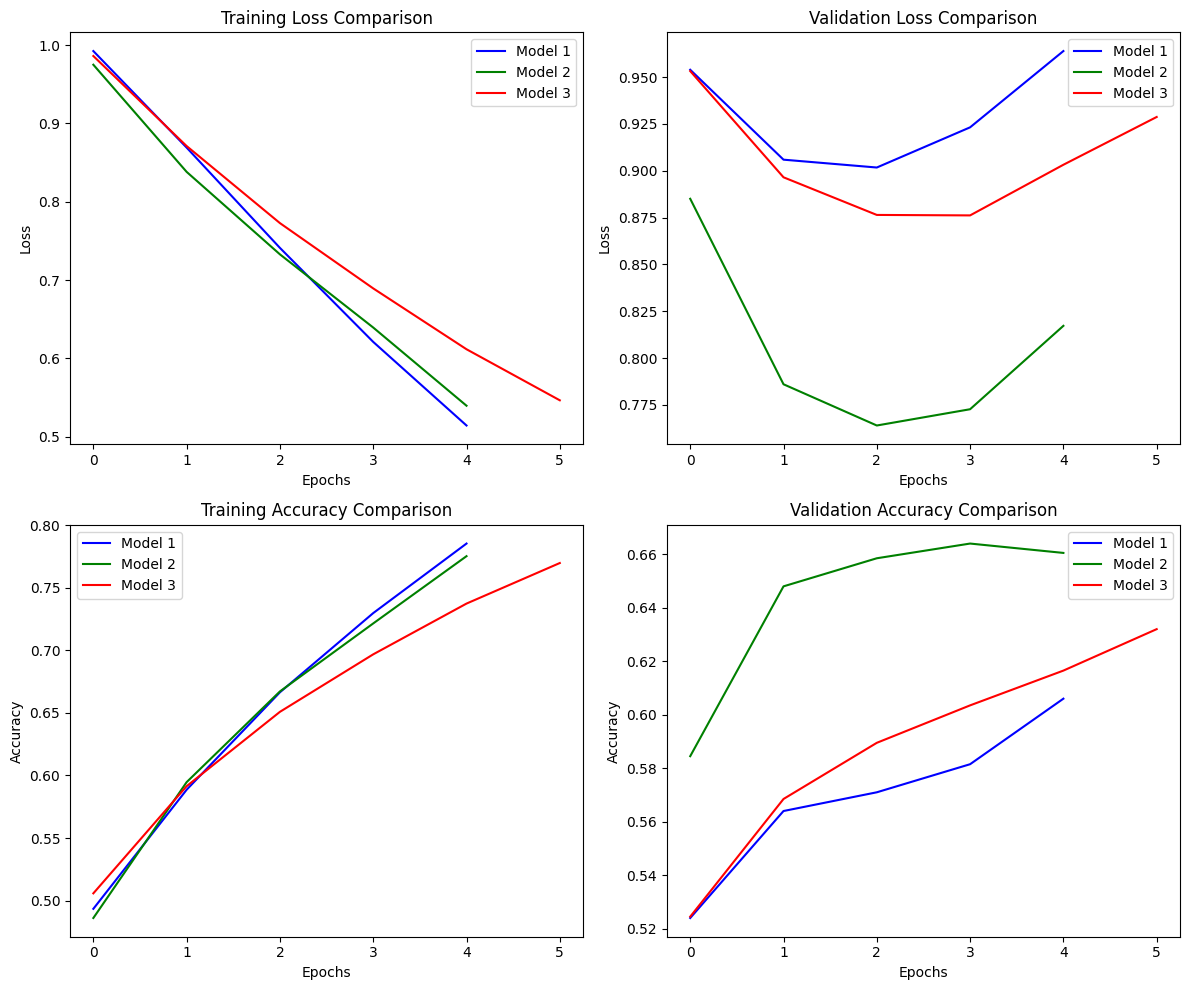

In [108]:
# Create the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot train loss
axes[0, 0].plot(train_losses, label="Model 1", color='blue')
axes[0, 0].plot(train_losses2, label="Model 2", color='green')
axes[0, 0].plot(train_losses1, label="Model 3", color='red')
axes[0, 0].set_title("Training Loss Comparison")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

# Plot validation loss
axes[0, 1].plot(val_losses, label="Model 1", color='blue')
axes[0, 1].plot(val_losses2, label="Model 2", color='green')
axes[0, 1].plot(val_losses1, label="Model 3", color='red')
axes[0, 1].set_title("Validation Loss Comparison")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot train accuracy
axes[1, 0].plot(train_accuracies, label="Model 1", color='blue')
axes[1, 0].plot(train_accuracies2, label="Model 2", color='green')
axes[1, 0].plot(train_accuracies1, label="Model 3", color='red')
axes[1, 0].set_title("Training Accuracy Comparison")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].legend()

# Plot validation accuracy
axes[1, 1].plot(val_accuracies, label="Model 1", color='blue')
axes[1, 1].plot(val_accuracies2, label="Model 2", color='green')
axes[1, 1].plot(val_accuracies1, label="Model 3", color='red')
axes[1, 1].set_title("Validation Accuracy Comparison")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].legend()

# Display the plot
plt.tight_layout()
plt.show()

Model 1 shows signs of overfitting, as its training performance continues to improve while its validation performance plateaus or declines.
Model 2 seems to generalize better than Model 1, with a more stable increase in validation accuracy and a plateauing of validation loss.
Model 3 appears to achieve the best validation accuracy among the three models after 5 epochs, suggesting it might be the most effective at generalizing to new data in this scenario.

Model 2 demonstrates the best generalization performance based on the validation accuracy achieved. It also maintains a high training accuracy.
Model 1 shows good improvement on the training data but its validation accuracy seems to plateau, suggesting it might be starting to overfit.
Model 3 shows consistent improvement in both training and validation accuracy but doesn't reach the same level as Model 1 and Model 2 on the validation set.